In [1]:
import xml.etree.ElementTree as ET
from operator import itemgetter

import keras.models
import keras.layers
from keras.callbacks import History
from keras.utils.vis_utils import model_to_dot

import numpy as np
import numpy.random
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import SVG

import sananmuunnin as sm
from one_hot import OneHot

plt.style.use('seaborn-darkgrid')
# TODO set seed

c:\users\con_jmerilai\appdata\local\continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
MAX_LEN = 20
KOTUS_WORD_LIST = "./kotus/kotus-sanalista_v1.xml"
MODEL_PATH = "./sm-seq2seq.h5"
CHARACTERS = ["", " "] + list(sm.VOWELS + sm.CONSONANTS)

HIDDEN_SIZE = 80
BATCH_SIZE = 128
EPOCHS = 20

TRAIN_SIZE = 250000
VAL_SIZE = 50000

In [3]:
def read_kotus_words(filename, characters, max_len):
    def is_valid(word):
        return (
            all(char in characters for char in word) and
            len(word) < max_len / 2
        )

    return [
        s.text for s in ET.parse(filename).iterfind("st/s")
        if is_valid(s.text)
    ]

words = read_kotus_words(KOTUS_WORD_LIST, CHARACTERS, MAX_LEN)
words[:5]

['aakkonen', 'aakkostaa', 'aakkosto', 'aakkostus', 'aallokas']

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 80)                35840     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 80)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 80)            51520     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 31)            2511      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 31)            0         
Total params: 89,871
Trainable params: 89,871
Non-trainable params: 0
_________________________________________________________________


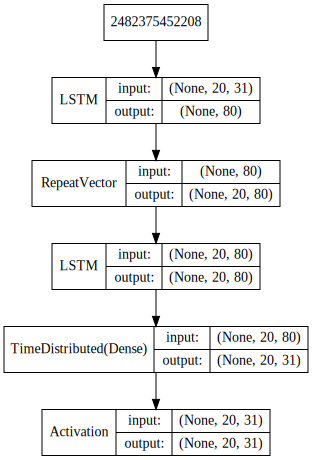

In [4]:
encoder = OneHot(CHARACTERS, MAX_LEN)
max_len = encoder.max_len
characters = encoder.characters
n_characters = encoder.n_characters

model = keras.models.Sequential(
    [
        keras.layers.LSTM(HIDDEN_SIZE, input_shape=(max_len, n_characters)),
        keras.layers.RepeatVector(max_len),
        keras.layers.LSTM(HIDDEN_SIZE, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(n_characters)),
        keras.layers.Activation("softmax"),
    ]
)

model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

model.summary()
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog="dot", format="svg"))

In [5]:
def generate_data(words, encoder, size):

    def _generate_data():
        word_indices = np.random.randint(0, len(words), (size, 2))
        for pair_indices in word_indices:
            input_words = itemgetter(*pair_indices)(words)
            output_words = sm.process(*input_words)
            yield (
                encoder.encode(" ".join(input_words)),
                encoder.encode(" ".join(output_words)),
            )

    x, y = zip(*_generate_data())
    return np.stack(x, axis=0), np.stack(y, axis=0)

x_train, y_train = generate_data(words, encoder, TRAIN_SIZE)
x_val, y_val = generate_data(words, encoder, VAL_SIZE)

x_train.shape, y_train.shape

((250000, 20, 31), (250000, 20, 31))

In [6]:
history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[History()],
    verbose=2,
)

Train on 250000 samples, validate on 50000 samples
Epoch 1/20
 - 153s - loss: 1.9594 - acc: 0.3974 - val_loss: 1.6064 - val_acc: 0.4866
Epoch 2/20
 - 182s - loss: 1.4164 - acc: 0.5402 - val_loss: 1.2125 - val_acc: 0.5984
Epoch 3/20
 - 141s - loss: 1.0664 - acc: 0.6451 - val_loss: 0.9479 - val_acc: 0.6826
Epoch 4/20
 - 141s - loss: 0.8677 - acc: 0.7124 - val_loss: 0.7596 - val_acc: 0.7460
Epoch 5/20
 - 141s - loss: 0.7024 - acc: 0.7698 - val_loss: 0.6141 - val_acc: 0.7993
Epoch 6/20
 - 184s - loss: 0.5570 - acc: 0.8190 - val_loss: 0.5336 - val_acc: 0.8245
Epoch 7/20
 - 181s - loss: 0.4385 - acc: 0.8614 - val_loss: 0.3784 - val_acc: 0.8811
Epoch 8/20
 - 175s - loss: 0.3415 - acc: 0.8932 - val_loss: 0.3099 - val_acc: 0.9031
Epoch 9/20
 - 162s - loss: 1.1599 - acc: 0.7626 - val_loss: 1.3369 - val_acc: 0.7797
Epoch 10/20
 - 174s - loss: 1.2110 - acc: 0.8239 - val_loss: 1.1628 - val_acc: 0.8392
Epoch 11/20
 - 169s - loss: 1.0911 - acc: 0.8633 - val_loss: 1.0611 - val_acc: 0.8718
Epoch 12/20


In [ ]:
model.save(MODEL_PATH)

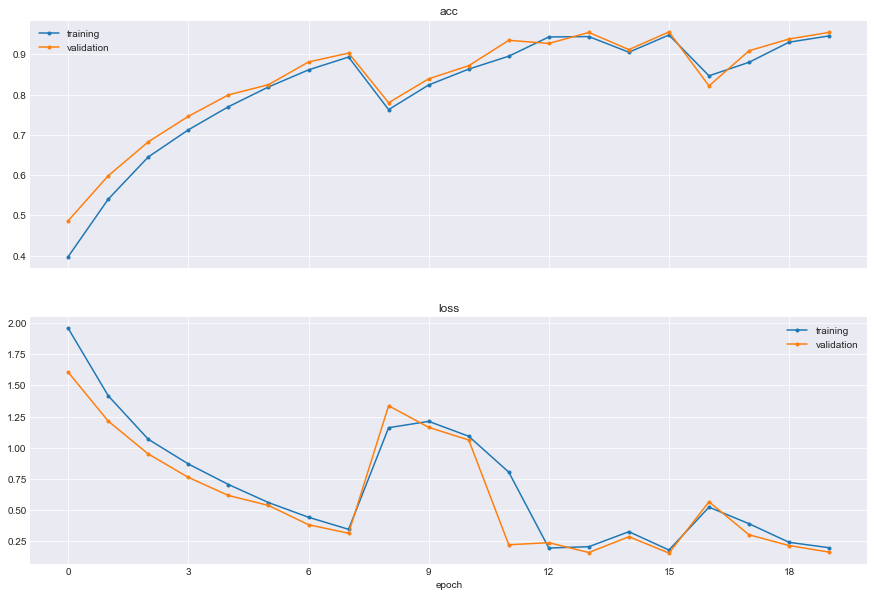

In [7]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

for ax, value in zip(axes, ("acc", "loss")):
    ax.plot(history.history[value], 'o-', ms=3, label="training")
    ax.plot(history.history[f"val_{value}"], 'o-', ms=3, label="validation")
    ax.set_title(value)
    ax.legend()

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("epoch");

In [8]:
def predict(model, encoder, words):
    x = encoder.encode(words)[np.newaxis]
    y = model.predict(x)[0]
    return encoder.decode(y)

In [33]:
predict(model, encoder, "muistakaa hana")

'haistakaa muna'